In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import random
import math

import pickle
import os

In [9]:
from simulator import AELayer, spk_t, default_spike_eval

def my_stdp(ref_time, run_time, curr_time, spike_to_value,
            t_minus, t_plus, weights, min_w, max_w, learn_rate,
            last_pre_spikes, pre_spikes, 
            post_spikes, target_spikes):
    w = weights
    # time weight <==> sooner spikes (t->ref) should be more important    
    tw = spike_to_value(ref_time, run_time, curr_time, 1.)

#     # weight updates
#     left_bound = max(t-tau_stdp+1-delay, 0)
    if (post_spikes>0).any() or (target_spikes>0).any():
#         print("post_spikes")
#         print(post_spikes)
#         print("target_spikes")
#         print(target_spikes)
        rows = np.where( np.logical_and(last_pre_spikes > (curr_time - t_minus), last_pre_spikes >= 0) )[0]
#         print("ROWS")
#         print(rows)
        if len(rows):
            w[rows, :] += learn_rate*np.outer(last_pre_spikes[rows,0], target_spikes[:, 0])*tw
            w[rows, :] -= learn_rate*np.outer(last_pre_spikes[rows,0], post_spikes[:, 0])*tw
        
        cols = np.where( target_spikes > 0 )[0]
#         print("np.outer")
#         print(np.outer(np.ones_like(pre_spikes, dtype=spk_t), target_spikes[cols, 0]))
#         print("w column")
#         print(w[:, 0])
#         print("pre mult")
#         print(np.ones_like(pre_spikes, dtype=spk_t))
#         print("target cols")
#         print(target_spikes[cols, 0])
        w[:, cols] += (learn_rate*tw)*np.outer(np.ones_like(pre_spikes, dtype=spk_t), target_spikes[cols, 0])
        cols = np.where( post_spikes > 0 )[0]
        w[:, cols] -= (learn_rate*tw)*np.outer(np.ones_like(pre_spikes, dtype=spk_t), post_spikes[cols, 0])

        w[w>max_w] = max_w
        w[w<min_w] = min_w

    return w

In [3]:
np.random.seed(10)
# www = np.arange(3*2).reshape((3, 2))
# www.T[1, :] = 333
# print(www)
# #network configuraiton
# v_size = 21
# h_size = 50



In [4]:
import mnist_utils as mu
train_x, train_y = mu.get_train_data()
train_x /= 255. # <- wouldn't this make it [0., 1.]?
in_size = 794
hid_size = 500
run_time = 30
delay = 5.
tgt_delay = 10.
description = {'level': 0,
               'run_time': run_time,
               'sizes': {'in': in_size, 'hid': hid_size, 'rcn': in_size},
               'delays': {'in': delay*np.ones(in_size),
                          'hid': delay*np.ones(hid_size),
                          'rcn': delay*np.ones(in_size)},
               'in_times': np.zeros((in_size, 1)),
               'neuron_params': {'v_thresh': 1.,   # membrane potential threshold
                                 'v_rest':   0.,     # resting potential
                                 'tau_m':    20.,},
               'stdp': {'func':       my_stdp,
                        'max_w':      0.5,
                        'min_w':     -0.5,
                        't_plus':     20.,
                        't_minus':    20.,
                        'learn_rate': 0.001,
                        'target_times': np.zeros((in_size, 1), dtype=np.int32),
                        'target_delay': tgt_delay,},
              }



epoch:0


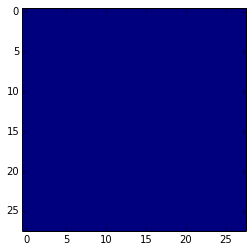

epoch:1


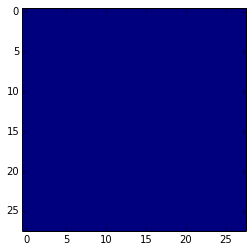

epoch:2


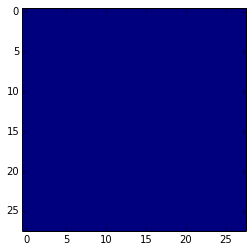

epoch:3


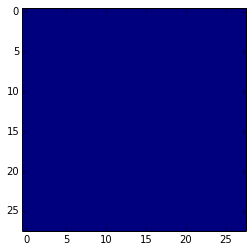

epoch:4


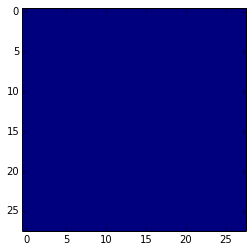

epoch:5


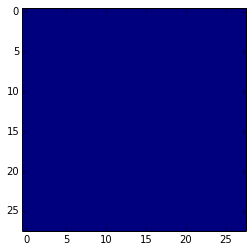

epoch:6


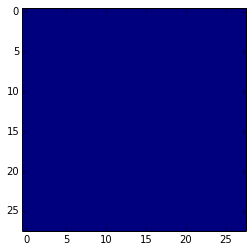

epoch:7


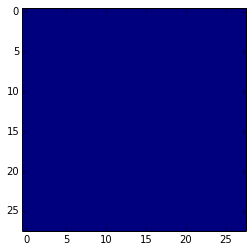

epoch:8


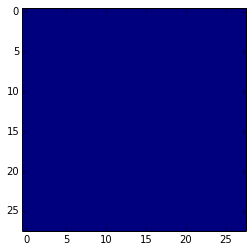

epoch:9


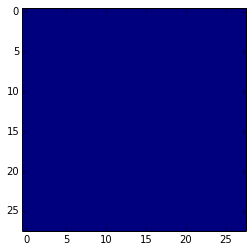

epoch:10


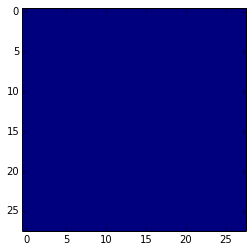

epoch:11


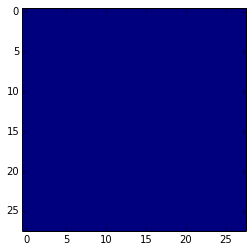

epoch:12


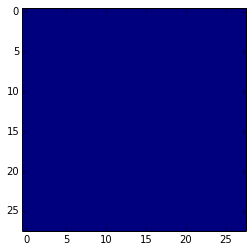

epoch:13


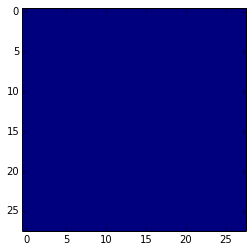

epoch:14


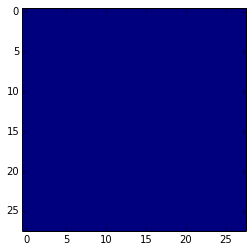

epoch:15


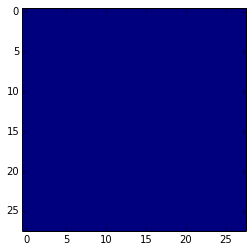

epoch:16


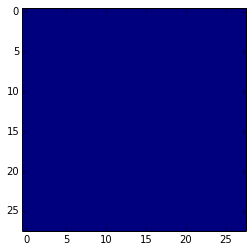

epoch:17


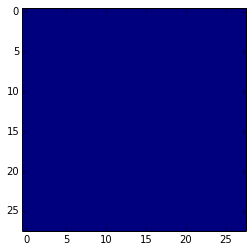

epoch:18


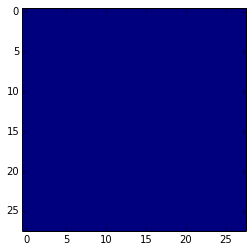

epoch:19


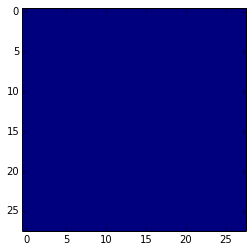

epoch:20


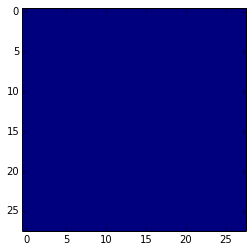

epoch:21


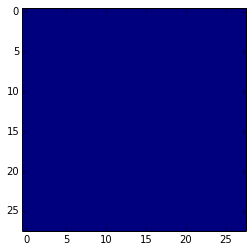

epoch:22


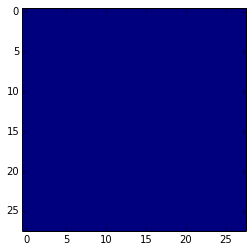

epoch:23


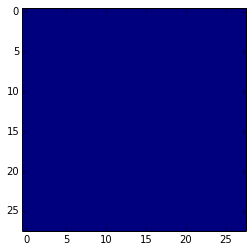

epoch:24


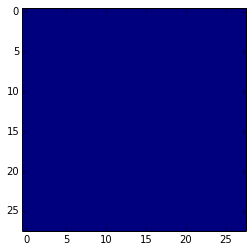

epoch:25


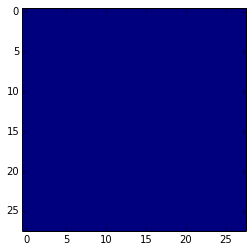

epoch:26


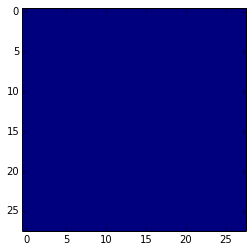

epoch:27


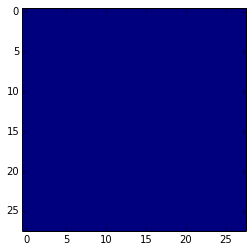

epoch:28


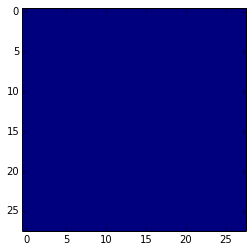

epoch:29


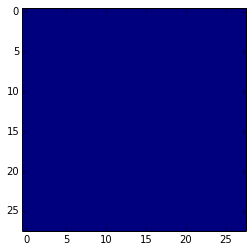

epoch:30


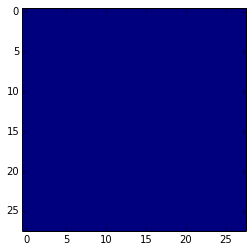

epoch:31


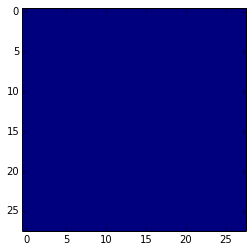

In [ ]:
epoch = 50 # training epochs
record_flag = False
# Recording of the neural status
if record_flag:
#     h_mem_list = []     # membrane potential of hiden units 
#     h_spike_list = []   # spikes of hiden units 
#     o_mem_list = []     # membrane potential of output units 
#     o_spike_list = []   # spikes of output units 
    w_list = []         # weights
    loss_list = []
    predict_list = []


lvl_0 = AELayer(description)
prev_w  = lvl_0._w.copy()
period = 33

num_test = 1
patterns = np.int16(np.floor((1.-train_x[:num_test])*period ))
patterns_y = np.zeros((num_test, 10))
patterns_y[range(num_test), np.int16(train_y[:num_test])] = 1.
patterns_y = np.int16(np.floor((1.-patterns_y[:num_test])*period ))
patterns = np.append(patterns,patterns_y, axis=1)

sample = np.empty(patterns[0,:].T.shape, dtype=np.int32).reshape((-1, 1))
target = np.empty(patterns[0,:].T.shape, dtype=np.int32).reshape((-1, 1))
recons = np.zeros((patterns[0,:].T.size, run_time))
tw = 0.
ref_time = 0.
for iteration in range(epoch):
    print 'epoch:%d'%iteration
    for p_id in range(patterns.shape[0]):
        # reset the neural status
        lvl_0.reset()
        
        # the input spikes and the teaching signal
        
        sample[:] = np.copy(patterns[p_id,:].T).reshape((-1, 1))
        target[:] = np.int32(np.copy(patterns[p_id,:].T).reshape((-1, 1)) + tgt_delay)
        
        lvl_0.reinput(sample)
        lvl_0.retarget(target)

        # Main part for neural status updating
        for t in range(run_time):
            tw = default_spike_eval(ref_time, run_time, t, 1.)
            recons[:, t] = lvl_0.sim(t)[:, 0]#*tw
        
        if p_id == 0:
            plt.figure()
            plt.imshow(recons.sum(axis=1)[:-10].reshape((28,28)))
            plt.show()
#         if np.mod(p_id,1)==0: #p_id == patterns.shape[0]-1:# and  np.mod(iteration,10) == 9: 
# #             print iteration
# #             neuron_id, time_stamp = np.where(o_spike==1)
# #             plt.plot(time_stamp, neuron_id, '.')
# #             plt.xlim((0,run_len))
# #             plt.show()
            
#             recon = (o_spike.argmax(axis=1)-teach_delay)*1.
            
#             recon[recon>=0] = (K-recon[recon>=0])/K
#             recon[recon<0] = 0
            
#             loss =  ((((K-patterns)/K)[p_id]-recon.flatten()) ** 2).mean()
# #             print 'Loss:', ((((K-patterns)/K)[p_id]-recon.flatten()) ** 2).mean()
            
#             predict = np.argmax(recon[-10:]) 

# #             print 'Predict: ', np.argmax(predict) 
# #             print predict
# #             recon_img = np.reshape(recon[:-10], (28,28))
# #             plt.imshow(recon_img, cmap=cm.gray_r, clim=(0,1))
# #             plt.show()
#             if record_flag:
#                 loss_list.append(loss)
# #                 predict_list.append(predict)
# #                 w_list.append(w.flatten())
#                 w_list.append(w[-10:,:].flatten())
#                 print p_id, '%0.3f'%loss, np.int16(train_y[p_id]), predict, '%.2f'%recon[-10+predict]
#     if np.mod(iteration,10) == 9:
#         delta_w *= 0.8

In [ ]:
# plt.plot(loss_list)
avg_num = 10
img_num = len(loss_list)
loss_plot = np.reshape(np.array(loss_list), (img_num/avg_num, avg_num))
plt.semilogy(np.average(loss_plot,axis=1))
plt.title('Loss (MSE)')


In [ ]:
w_list = np.array(w_list)
plt.plot(w_list[:,::10])
print w_list.shape